In [1]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import Dataset, DataLoader
from utils.data_loader import load_dataset
import torch

train_data, train_labels, test_data, test_labels = load_dataset("mnist", flatten=False, binarize=True, with_targets=True)

In [2]:
# set parameters for dataloader
device = "cpu"
use_cuda = False
if torch.cuda.is_available():
    device = "cuda"
    use_cuda = True
batch_size = 512

In [3]:
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x)
        self.y = torch.tensor(y)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
train_dataset = MyDataset(train_data, train_labels)
test_dataset = MyDataset(test_data, test_labels)

if use_cuda:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                                              num_workers=3)
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                            num_workers=3)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=False,
                                            )
    valloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                            )

пока сделаем тупую модель, которая будет работать с плоскими картинками

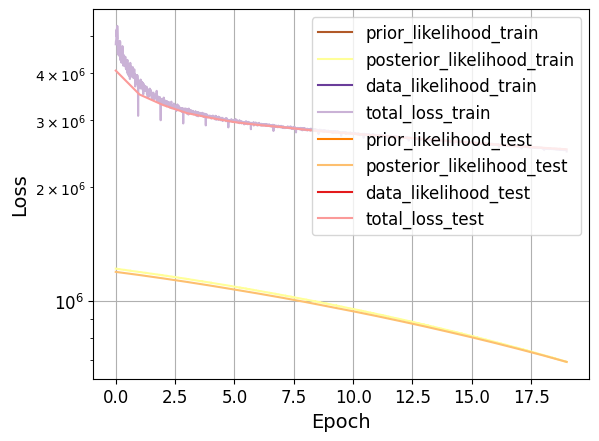

key='prior_likelihood' [-1785735.25, -1785507.0, -1785534.75, -1785627.875, -1785597.75]
key='posterior_likelihood' [692616.5, 692994.25, 692993.3125, 692619.625, 692441.875]
key='data_likelihood' [-364.0257873535156, -314.9761962890625, -302.6793518066406, -245.67933654785156, -65.93515014648438]
key='total_loss' [2514649.0, 2509924.5, 2506815.0, 2503689.5, 2484687.5]


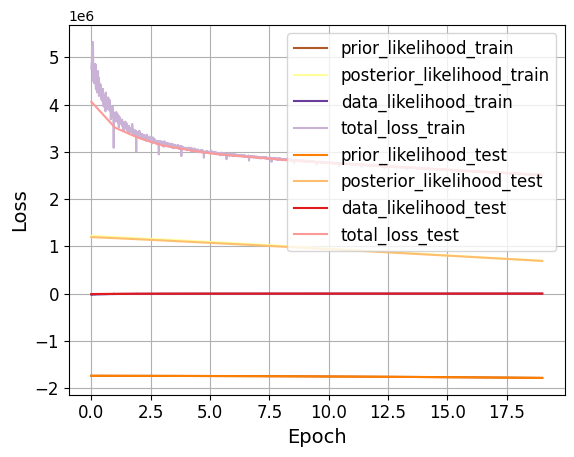

End of the training


In [4]:
%load_ext autoreload
%autoreload 2

import bayess
import bayess.nn as bnn
import torch.nn as nn
import bayess.resulting_types
from bayess.training import train_model

model_dimentions = [28 * 28, 1024, 1024, 10]
epochs = 20
n_samples = 8

return_type = bayess.resulting_types.RenuiLossModelOutput

model = bnn.BayessMLP(return_type, model_dimentions)

model = nn.Sequential(
      nn.Flatten(),
      model
)

data_loss = nn.CrossEntropyLoss(reduction="sum")
M = len(train_dataset)/batch_size
loss = bnn.RenuiLoss(data_loss= data_loss,batches_count= M, alpha= -100)


opt = torch.optim.Adam(model.parameters()) #, lr = 0.01) #, lr=0.001)

train_losses, test_losses = train_model(model,loss = loss, device = device, train_loader=trainloader, n_samples = n_samples,
                                test_loader=valloader, epochs=epochs,
            optimizer= opt, loss_key= 'total_loss', visualize_samples=True, logscale_y= True)

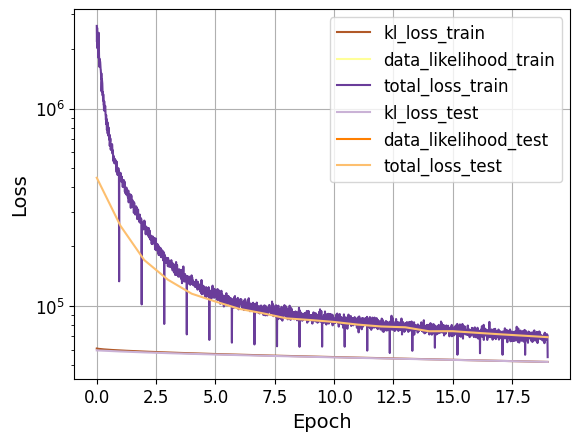

key='kl_loss' [51942.828125, 51940.16015625, 51937.4921875, 51934.81640625, 51932.15234375]
key='data_likelihood' [-163.528564453125, -148.8640899658203, -165.3061981201172, -129.89898681640625, -25.374832153320312]
key='total_loss' [71106.328125, 69385.171875, 71309.3046875, 67157.3515625, 54905.765625]


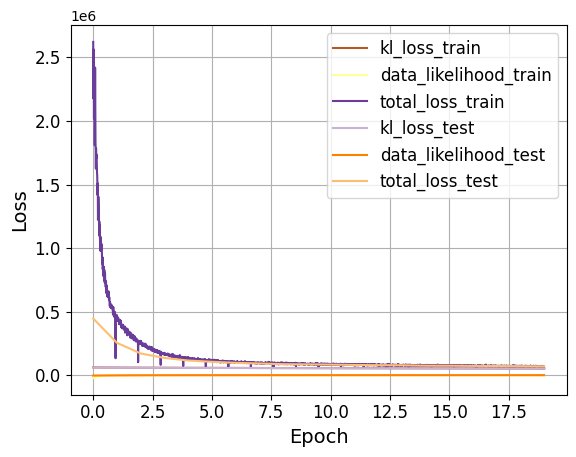

End of the training


In [9]:
%load_ext autoreload
%autoreload 2

import bayess
import bayess.nn as bnn
import torch.nn as nn
import bayess.resulting_types
from bayess.training import train_model

model_dimentions = [28 * 28, 1024, 1024, 10]
epochs = 20
n_samples = 8

return_type = bayess.resulting_types.KLLossModelOutput

model = bnn.BayessMLP(return_type, model_dimentions)

model = nn.Sequential(
      nn.Flatten(),
      model
)

data_loss = nn.CrossEntropyLoss(reduction="sum")
M = len(train_dataset)/batch_size
loss = bnn.KLLoss(data_loss= data_loss, beta = M)


opt = torch.optim.Adam(model.parameters()) #, lr = 0.01) #, lr=0.001)

train_losses, test_losses = train_model(model,loss = loss, device = device, train_loader=trainloader, n_samples = n_samples,
                                test_loader=valloader, epochs=epochs,
            optimizer= opt, loss_key= 'total_loss', visualize_samples=True, logscale_y= True)

In [10]:
from torch.nn import functional as F
items = []
model_tmp = model.to("cpu")
for layer  in model_tmp[1].net:
    if isinstance(layer, bnn.BayessLinear):
        P_div = layer.weight_mu.detach().abs() / F.softplus(layer.weight_sigma.detach(), beta = 1, threshold = 20)
        P_div = P_div.flatten().numpy() 
        items.append(P_div)
        P_div = layer.bias_mu.detach().abs() / F.softplus(layer.bias_mu.detach(), beta = 1, threshold = 20)
        P_div = P_div.flatten().numpy() 
        items.append(P_div)

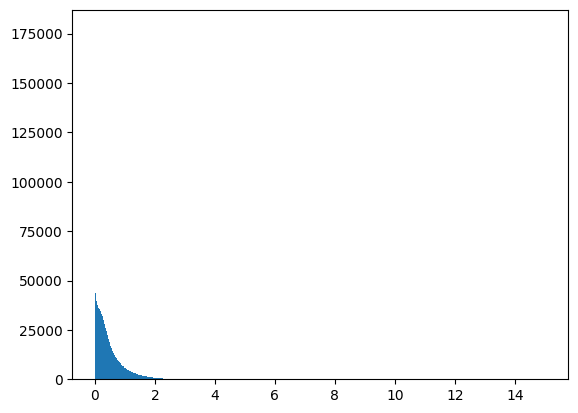

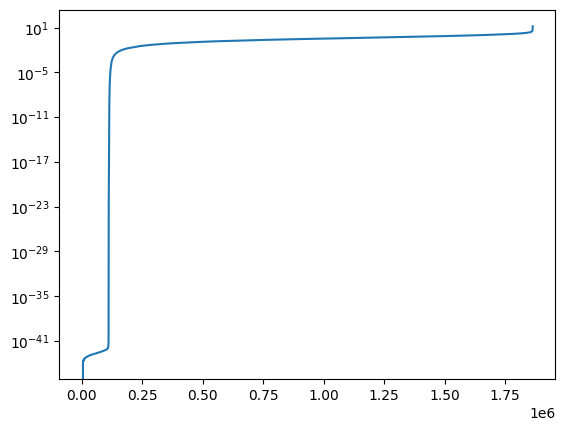

In [11]:
import numpy as np
import matplotlib.pyplot as plt
it = np.concatenate(items)
plt.hist(it, bins = 1100)
plt.show()
plt.plot(sorted(it))
plt.yscale("log")

In [12]:
st_dct = model.state_dict()
torch.save(st_dct, "200_epoch_model.pt")

In [21]:
from bayess.nn.net import MLP
def BayessMLP2MLP(model, threshold):
    """
    zeroing partiton states how match parameters will be set to 0
    """
    model_new = MLP(model.dimentions)
    state_dict = {}
    bayess_sd = model.state_dict()
    for key in model_new.state_dict().keys():        
        key_mu = key + "_mu"
        key_sigma = key + "_sigma"        

        weights = bayess_sd[key_mu].detach().clone()
        
        sigma_detach = torch.zeros_like(bayess_sd[key_sigma]).detach()
        sigma_detach = F.softplus(sigma_detach, beta = 1, threshold = 20)
        weights = weights * ((weights.abs()/sigma_detach) > threshold)
        
        state_dict[key] = weights.T
    model_new.load_state_dict(state_dict=state_dict)
    return model_new

    

In [22]:
xt, yt = [], []
for i in range(1000):
    x,y = test_dataset[i]
    xt.append(x)
    yt.append(y)
xt = torch.stack(xt, )
yt = torch.stack(yt)
xt.shape

torch.Size([1000, 1, 28, 28])

In [23]:
pytorch_total_params = sum(p.numel() for p in model.parameters())

q_s = np.linspace(0.01, 0.99, 40)
accs = []
for q in q_s:
    val = float(np.quantile(it, q))
    
    model_bias = model[1]
    model_unb = BayessMLP2MLP(model_bias, val)
    model_unb = nn.Sequential(
            nn.Flatten(),
            model_unb
    )
    acc = (model_unb(xt).argmax(1) == yt).float().mean()
    accs.append(acc)
    print(f"{q=}  params: {pytorch_total_params * (1 - q)}:  {val=}  : {acc=}")

/tmp/ipykernel_79128/3038484683.py:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  state_dict[key] = weights.T


q=np.float64(0.01)  params: 3690106.2:  val=6.866362475191604e-44  : acc=tensor(0.9350)
q=np.float64(0.03512820512820513)  params: 3596443.8307692306:  val=2.6064151436441598e-43  : acc=tensor(0.9350)
q=np.float64(0.06025641025641026)  params: 3502781.4615384615:  val=2.230163846495925e-15  : acc=tensor(0.9350)
q=np.float64(0.08538461538461538)  params: 3409119.0923076924:  val=0.008121545426547527  : acc=tensor(0.9350)
q=np.float64(0.1105128205128205)  params: 3315456.723076923:  val=0.022183289751410484  : acc=tensor(0.9360)
q=np.float64(0.13564102564102565)  params: 3221794.3538461537:  val=0.03753418102860451  : acc=tensor(0.9350)
q=np.float64(0.16076923076923078)  params: 3128131.9846153846:  val=0.053478773683309555  : acc=tensor(0.9340)
q=np.float64(0.1858974358974359)  params: 3034469.6153846155:  val=0.0700334683060646  : acc=tensor(0.9370)
q=np.float64(0.21102564102564103)  params: 2940807.246153846:  val=0.08709468692541122  : acc=tensor(0.9350)
q=np.float64(0.23615384615384

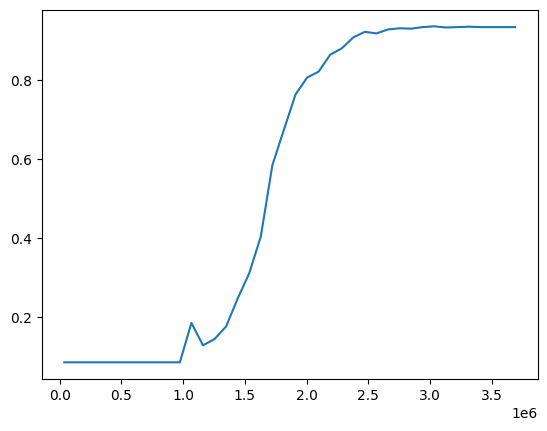

In [24]:
to = 0
plt.plot((1-q_s[to:]) * pytorch_total_params, accs[to:])

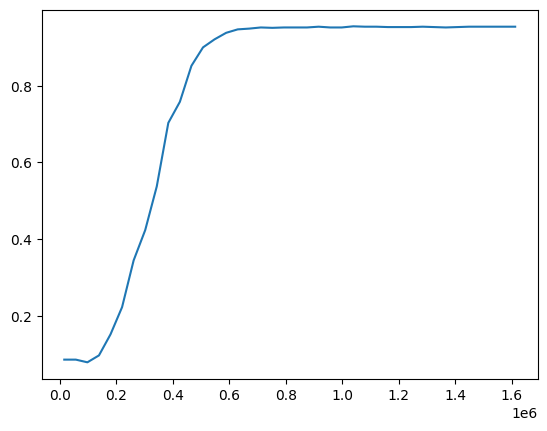

In [ ]:
to = 0
plt.plot((1-q_s[to:]) * pytorch_total_params, accs[to:])